In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import PIL
from ultralytics import YOLO

In [2]:
df=pd.read_pickle(r"E:\DroneFootageDataset\finaly.pkl")
df_u=df.drop_duplicates(["image_path"])
df_u.drop(columns=["xc","yc","w","h","entropy","hue_x","hue_y","entropy_rgb"], inplace=True)

C:\Users\posei\AppData\Local\Temp\ipykernel_2112\49589713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_u.drop(columns=["xc","yc","w","h","entropy","hue_x","hue_y","entropy_rgb"], inplace=True)


In [3]:
# pip install kornia opencv-python-headless
import os, math, gc, cv2, numpy as np, torch, kornia as K
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Тонкие настройки ---
DOWNSCALE     = 0.25          # ФИКСИРОВАННЫЙ даунскейл (1.0 оставить без изменений)
BATCH_SIZE    = 50           # подгоните под VRAM
READ_CHUNK    = BATCH_SIZE*2 # сколько изображений одновременно читаем с диска
READ_THREADS  = min(16, (os.cpu_count() or 8)*2)

def _read_rgb_uint8(path: str):
    """Быстрое чтение с фиксированным даунскейлом. Возвращает HxWx3 uint8 RGB или None."""
    try:
        data = np.fromfile(path, dtype=np.uint8)
        if data.size == 0:
            return None
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)  # BGR uint8
        if img is None:
            return None
        if DOWNSCALE != 1.0:
            h, w = img.shape[:2]
            img = cv2.resize(img,
                             (max(1, int(w*DOWNSCALE)), max(1, int(h*DOWNSCALE))),
                             interpolation=cv2.INTER_AREA)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return rgb
    except Exception:
        return None

@torch.inference_mode()
def _gpu_metrics_batch(rgb_list):
    """Метрики для батча изображений (список HxWx3 uint8 RGB, может содержать None)."""
    valid = [i for i,x in enumerate(rgb_list) if x is not None]
    if not valid:
        return [(np.nan, np.nan, np.nan, np.nan)] * len(rgb_list)

    # CHW u8 -> GPU -> float[0,1]
    xs = [torch.from_numpy(rgb_list[i]).permute(2,0,1).contiguous() for i in valid]
    x_u8 = torch.stack(xs, dim=0)                           # Bx3xHxW uint8
    x = x_u8.to(DEVICE, non_blocking=True).float() / 255.0  # Bx3xHxW

    # ---------- Энтропия по RGB (средняя) -> норм. в [0,1] ----------
    B = x.shape[0]
    x255 = (x * 255.0).round().clamp_(0, 255).to(torch.uint8)  # Bx3xHxW
    ent_list = []
    for c in range(3):
        ch = x255[:, c].reshape(B, -1).to(torch.float32)
        Hc = []
        for b in range(B):
            h = torch.histc(ch[b], bins=256, min=0, max=255)   # на GPU
            p = h / h.sum().clamp_min(1.0)
            e = -(p[p>0] * p[p>0].log2()).sum()
            Hc.append(e)
        ent_list.append(torch.stack(Hc))
    entropy_norm = (torch.stack(ent_list, dim=1).mean(dim=1) / 8.0).clamp(0,1)  # B

    # ---------- HSV ----------
    hsv = K.color.rgb_to_hsv(x)           # Bx3xHxW, все в [0,1]
    Hh, Ss, Vv = hsv[:,0], hsv[:,1], hsv[:,2]
    mean_s = Ss.mean(dim=(1,2))
    mean_v = Vv.mean(dim=(1,2))

    ang = 2*math.pi*Hh
    mean_x = torch.cos(ang).mean(dim=(1,2))
    mean_y = torch.sin(ang).mean(dim=(1,2))
    mean_h = torch.atan2(mean_y, mean_x)
    mean_h[mean_h < 0] += 2*math.pi
    mean_h01 = (mean_h / (2*math.pi)).clamp(0,1)

    # раскладываем обратно по исходным индексам (вставляя NaN для None)
    out = [(np.nan, np.nan, np.nan, np.nan)] * len(rgb_list)
    j = 0
    for i in range(len(rgb_list)):
        if rgb_list[i] is not None:
            out[i] = (float(entropy_norm[j]),
                      float(mean_h01[j]),
                      float(mean_s[j]),
                      float(mean_v[j]))
            j += 1

    # подчистка батча (RAM/VRAM)
    del x, x_u8, x255, hsv, Hh, Ss, Vv, mean_x, mean_y, mean_h, mean_h01, entropy_norm, ent_list
    torch.cuda.empty_cache()
    gc.collect()
    return out

def _process_chunk(paths_chunk):
    """Читаем chunk потоками, затем считаем метрики, группируя по одинаковым размерам."""
    # 1) читаем ограниченное число файлов
    rgb_list = [None]*len(paths_chunk)
    with ThreadPoolExecutor(max_workers=READ_THREADS) as ex:
        fut2i = {ex.submit(_read_rgb_uint8, p): i for i, p in enumerate(paths_chunk)}
        for fut in as_completed(fut2i):
            i = fut2i[fut]
            rgb_list[i] = fut.result()

    # 2) сгруппируем индексы по размерам
    groups = {}  # (H,W) -> [idx...]
    for idx, img in enumerate(rgb_list):
        if img is None:
            continue
        h, w = img.shape[:2]
        groups.setdefault((h, w), []).append(idx)

    res = [(np.nan, np.nan, np.nan, np.nan)] * len(paths_chunk)

    # 3) обрабатываем каждую группу батчами (без паддинга и ресайза)
    for (h, w), idxs in groups.items():
        # идём батчами внутри группы
        for start in range(0, len(idxs), BATCH_SIZE):
            part_idx = idxs[start:start+BATCH_SIZE]
            part_imgs = [rgb_list[i] for i in part_idx]   # все одинакового размера
            met = _gpu_metrics_batch(part_imgs)           # безопасно стэкнется

            for k, i in enumerate(part_idx):
                res[i] = met[k]

            # подчистка батча
            del part_idx, part_imgs, met
            torch.cuda.empty_cache()
            gc.collect()

    # подчистка после чанка
    del rgb_list, groups
    gc.collect()
    return res

def add_image_metrics_gpu_streaming(df: pd.DataFrame, image_path_col="image_path") -> pd.DataFrame:
    df=df.drop_duplicates(subset=["image_path"])
    paths = df[image_path_col].tolist()
    N = len(paths)
    print(N)
    results = [None]*N
    pbar=tqdm.tqdm(range(0, N, READ_CHUNK))
    for i in pbar:
        chunk_idx = list(range(i, min(i+READ_CHUNK, N)))
        paths_chunk = [paths[j] for j in chunk_idx]
        res_chunk = _process_chunk(paths_chunk)
        for local_k, j in enumerate(chunk_idx):
            results[j] = res_chunk[local_k]
        # подчистка после чанка
        del paths_chunk, res_chunk, chunk_idx
        torch.cuda.empty_cache()
        gc.collect()

    # В столбцы
    entropy = np.array([r[0] for r in results], dtype=np.float32)
    mean_h  = np.array([r[1] for r in results], dtype=np.float32)
    mean_s  = np.array([r[2] for r in results], dtype=np.float32)
    mean_v  = np.array([r[3] for r in results], dtype=np.float32)

    out = df.copy()
    out["entropy"] = entropy
    out["mean_hue"] = mean_h
    out["mean_saturation"] = mean_s
    out["mean_value"] = mean_v
    return out

# === пример использования ===
df = add_image_metrics_gpu_streaming(df, image_path_col="image_path")


34728


100%|██████████| 348/348 [19:39<00:00,  3.39s/it]


In [4]:
df.to_csv("smth.csv")

In [4]:
df=pd.read_csv(r"E:\DroneFootageDataset\smth.csv")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import cv2

# ==== параметры ====
k = 5  # число кластеров
image_col = 'image_path'  # имя колонки с путями к изображениям

# ==== обучаем k-means ====
features = df[['entropy', 'mean_hue', 'mean_saturation', 'mean_value']].values
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(features)


In [36]:
import pickle

filename = 'kmeans_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(kmeans, file)

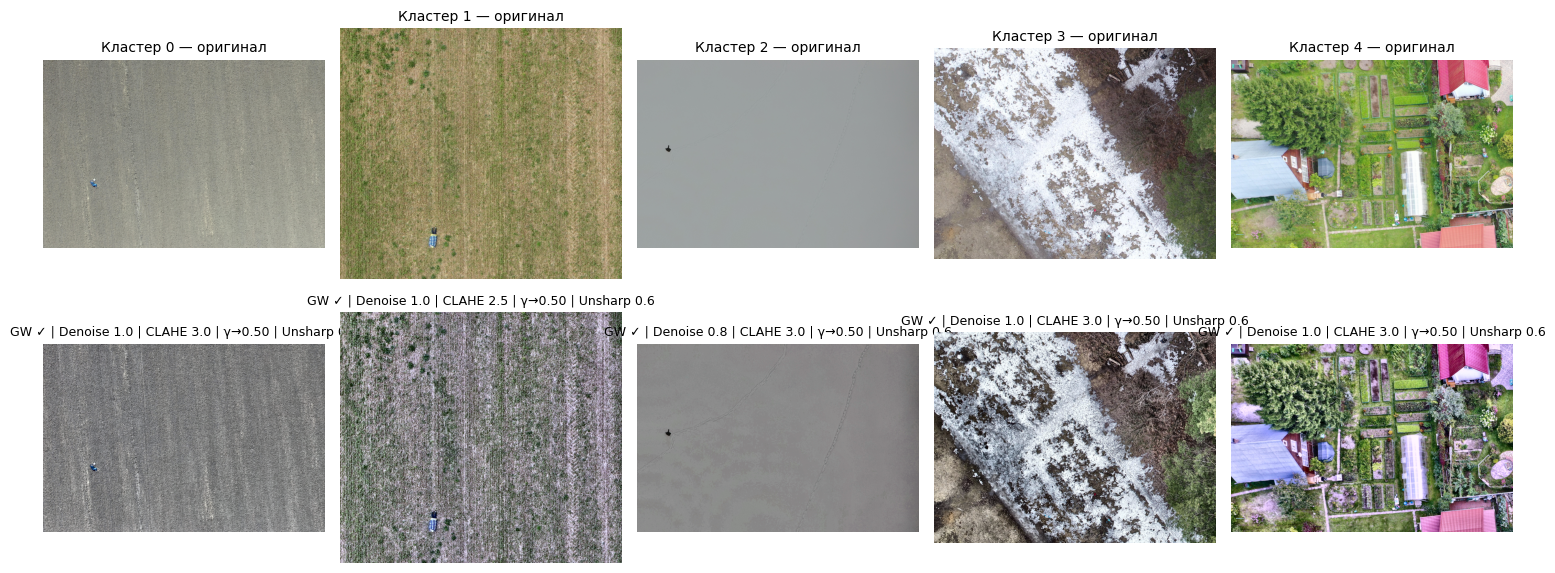

In [6]:
def gray_world_balance(img_bgr):
    # Gray-World WB: выравниваем средние знач. каналов
    img = img_bgr.astype(np.float32)
    mean_b, mean_g, mean_r = img[...,0].mean(), img[...,1].mean(), img[...,2].mean()
    mean_gray = (mean_b + mean_g + mean_r) / 3.0 + 1e-6
    img[...,0] *= (mean_gray / (mean_b + 1e-6))
    img[...,1] *= (mean_gray / (mean_g + 1e-6))
    img[...,2] *= (mean_gray / (mean_r + 1e-6))
    return np.clip(img, 0, 255).astype(np.uint8)

def soft_denoise(img_bgr, method='bilateral', strength=1.0):
    # Мягкое подавление шума (деликатно!)
    if method == 'nlmeans':
        # h: 3–7 достаточно мягко; шаблон/поиск по умолчанию
        h = int(5 * strength)
        return cv2.fastNlMeansDenoisingColored(img_bgr, None, h, h, 7, 21)
    else:
        # Bilateral мягче по краям, не «съедает» контуры
        d = 7
        sigma = int(25 * strength)
        return cv2.bilateralFilter(img_bgr, d, sigma, sigma)

def clahe_L(img_bgr, clip=2.5, tiles=(8,8)):
    # CLAHE по L-каналу в LAB
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tiles)
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def adaptive_gamma(img_bgr, target_mean=0.5, clip_gamma=(0.7, 1.3)):
    # Адаптивная гамма по средней яркости
    # Переводим в YCrCb и меряем среднюю яркость
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    Y = ycrcb[...,0].astype(np.float32) / 255.0
    mean_y = float(Y.mean() + 1e-6)
    # gamma = log(target)/log(mean)
    gamma = np.log(max(target_mean,1e-6)) / np.log(mean_y)
    gamma = float(np.clip(gamma, clip_gamma[0], clip_gamma[1]))
    # Применяем гамму к BGR (по каналам)
    img = np.clip(img_bgr.astype(np.float32) / 255.0, 0, 1)
    img = np.power(img, gamma)
    return np.clip(img * 255.0, 0, 255).astype(np.uint8)

def unsharp_mask(img_bgr, sigma=1.2, amount=0.6):
    # Unsharp: img + amount*(img - blur(img))
    blur = cv2.GaussianBlur(img_bgr, (0,0), sigma)
    sharp = cv2.addWeighted(img_bgr, 1 + amount, blur, -amount, 0)
    return sharp

def preprocess_pipeline(img_bgr, params):
    """
    Порядок строго фиксирован:
    1) Gray-World
    2) Мягкое подавление шума
    3) CLAHE(L)
    4) Адаптивная гамма
    5) Unsharp mask
    """
    out = img_bgr
    if params.get('gray_world', True):
        out = gray_world_balance(out)
    if params.get('denoise_strength', 0) > 0:
        out = soft_denoise(out,
                           method=params.get('denoise_method', 'bilateral'),
                           strength=params.get('denoise_strength', 1.0))
    if params.get('clahe_clip', 0) > 0:
        out = clahe_L(out, clip=params.get('clahe_clip', 2.5),
                           tiles=params.get('clahe_tiles', (8,8)))
    out = adaptive_gamma(out,
                         target_mean=params.get('gamma_target_mean', 0.5),
                         clip_gamma=params.get('gamma_clip', (0.7, 1.3)))
    if params.get('unsharp_amount', 0) > 0:
        out = unsharp_mask(out,
                           sigma=params.get('unsharp_sigma', 1.2),
                           amount=params.get('unsharp_amount', 0.6))
    return out

# ========= ЭВРИСТИКИ ДЛЯ РАЗНЫХ КЛАСТЕРОВ (кастомизация параметров) =========
# Можно использовать статические настройки, а можно подстроить их от статистики кластера.
cluster_stats = df.groupby('cluster')[['entropy','mean_value','mean_saturation']].mean()

def params_for_cluster(cid):
    """
    Пример разумных эвристик:
    - тёмные сцены (низкий mean_value) → gamma повыше (target_mean 0.55–0.6), CLAHE чуть сильнее
    - шумные сцены (высокая entropy) → чутка сильнее denoise, но аккуратно
    - низкая насыщенность → можно чуть поднять контраст через CLAHE
    """
    row = cluster_stats.loc[cid]
    mv = float(row['mean_value'])
    ent = float(row['entropy'])
    ms = float(row['mean_saturation'])

    # Базовые
    p = {
        'gray_world': True,
        'denoise_method': 'bilateral',
        'denoise_strength': 0.8,   # 0..1.2 мягко
        'clahe_clip': 2.5,
        'clahe_tiles': (8,8),
        'gamma_target_mean': 0.5,
        'gamma_clip': (0.7, 1.3),
        'unsharp_sigma': 1.2,
        'unsharp_amount': 0.6
    }

    # Темнота → чуть выше target_mean и посильнее CLAHE
    if mv < 0.42:
        p['gamma_target_mean'] = 0.58
        p['clahe_clip'] = 3.0
    elif mv > 0.65:
        # Слишком светлые сцены – слегка понижаем target_mean
        p['gamma_target_mean'] = 0.47

    # Шум/текстура → немного сильнее denoise при высок. энтропии
    if ent > 0.65:
        p['denoise_strength'] = 1.0
    elif ent < 0.35:
        # Гладкие сцены – меньше denoise, больше резкости
        p['denoise_strength'] = 0.5
        p['unsharp_amount'] = 0.7

    # Слабая насыщенность → чуть мощнее CLAHE
    if ms < 0.3:
        p['clahe_clip'] = max(p['clahe_clip'], 3.0)

    return p

# ========= ВЫБОР ПО ОДНОМУ ИЗОБРАЖЕНИЮ ИЗ КАЖДОГО КЛАСТЕРА =========
samples = []
for cid in range(k):
    sub = df[df['cluster'] == cid]
    if len(sub) == 0:
        samples.append((cid, None))
    else:
        samples.append((cid, random.choice(sub[image_col].tolist())))

# ========= ВИЗУАЛИЗАЦИЯ: 2 РЯДА (оригинал / после препроцессинга) =========
fig, axes = plt.subplots(2, k, figsize=(3*k, 6))
if k == 1:
    axes = np.array([[axes[0]], [axes[1]]])  # приведение к [2, k]

for col, (cid, path) in enumerate(samples):
    ax_top = axes[0, col]
    ax_bot = axes[1, col]
    ax_top.axis('off'); ax_bot.axis('off')

    if path is None:
        ax_top.text(0.5, 0.5, f"Кластер {cid}\n(пустой)", ha='center', va='center')
        ax_bot.text(0.5, 0.5, f"(нет данных)", ha='center', va='center')
        continue

    bgr = cv2.imread(path)
    if bgr is None:
        ax_top.text(0.5, 0.5, f"Кластер {cid}\n(не удалось открыть)", ha='center', va='center')
        ax_bot.text(0.5, 0.5, f"(нет данных)", ha='center', va='center')
        continue

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    ax_top.imshow(rgb)
    ax_top.set_title(f"Кластер {cid} — оригинал", fontsize=10)

    # Параметры по кластеру (можно заменить на единые константы, если не нужно разветвление)
    p = params_for_cluster(cid)
    bgr_proc = preprocess_pipeline(bgr, p)
    rgb_proc = cv2.cvtColor(bgr_proc, cv2.COLOR_BGR2RGB)
    ax_bot.imshow(rgb_proc)

    # Краткая подпись с ключевыми параметрами
    subtitle = (f"GW ✓ | Denoise {p['denoise_strength']:.1f} | "
                f"CLAHE {p['clahe_clip']:.1f} | γ→{p['gamma_target_mean']:.2f} | "
                f"Unsharp {p['unsharp_amount']:.1f}")
    ax_bot.set_title(subtitle, fontsize=9)

plt.tight_layout()
plt.show()



In [8]:
import os
import math
import pandas as pd
import numpy as np
import cv2

def _read_yolo_txt(txt_path):
    anns = []
    if not os.path.exists(txt_path):
        return anns
    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            try:
                lbl = int(float(parts[0]))
                xc, yc, w, h = map(float, parts[1:5])
                anns.append((lbl, xc, yc, w, h))
            except Exception:
                continue
    return anns

def _tile_starts(L, size, stride):
    """Список стартов так, чтобы покрыть край (как в sliding-window с 'последним' тайлом у правого/нижнего края)."""
    if L <= size:
        return [0]
    starts = list(range(0, max(L - size, 0) + 1, stride))
    last = L - size
    if starts[-1] != last:
        starts.append(last)
    return starts

def build_tiled_annotations(df: pd.DataFrame,
                            window_size: int = 640,
                            stride: int = 580,
                            save_txt: bool = False,
                            output_dir: str = "./tile_annotations") -> pd.DataFrame:
    """
    Возвращает DataFrame с колонками:
      ['image_path','annotation_path','tile_id','tile_x0','tile_y0','tile_w','tile_h','tile_annotation_path','lines']
    где 'lines' — список строк YOLO (label xc yc w h) для тайла; если пуст, тайл пропущен.
    Если save_txt=True — пишет файлы .txt в output_dir и указывает пути в 'tile_annotation_path'.
    """
    rows = []
    if save_txt:
        os.makedirs(output_dir, exist_ok=True)

    for idx, row in df.iterrows():
        img_path = row['image_path']
        ann_path = row['label_path']

        # размеры кадра
        if 'width' in df.columns and 'height' in df.columns and not (pd.isna(row['width']) or pd.isna(row['height'])):
            W, H = int(row['width']), int(row['height'])
        else:
            img = cv2.imread(img_path)
            if img is None:
                # пропускаем, если не открывается
                continue
            H, W = img.shape[:2]

        anns = _read_yolo_txt(ann_path)

        xs = _tile_starts(W, window_size, stride)
        ys = _tile_starts(H, window_size, stride)

        tile_id = 0
        for y0 in ys:
            for x0 in xs:
                w_tile = min(window_size, W - x0)
                h_tile = min(window_size, H - y0)

                # собираем строки аннотаций для этого тайла
                lines = []
                for (lbl, xc, yc, w, h) in anns:
                    # пиксельные координаты центра и размеров в исходном кадре
                    cx = xc * W
                    cy = yc * H
                    bw = w * W
                    bh = h * H

                    # центр объекта должен попадать в тайл
                    if (x0 <= cx < x0 + w_tile) and (y0 <= cy < y0 + h_tile):
                        # переводим в норм. координаты тайла
                        xc_t = (cx - x0) / max(w_tile, 1e-6)
                        yc_t = (cy - y0) / max(h_tile, 1e-6)
                        w_t = bw / max(w_tile, 1e-6)
                        h_t = bh / max(h_tile, 1e-6)

                        # зажимаем в [0,1] на всякий
                        xc_t = float(np.clip(xc_t, 0.0, 1.0))
                        yc_t = float(np.clip(yc_t, 0.0, 1.0))
                        w_t = float(np.clip(w_t, 0.0, 1.0))
                        h_t = float(np.clip(h_t, 0.0, 1.0))

                        # лейбл всегда 0 по условию
                        lines.append(f"0 {xc_t:.6f} {yc_t:.6f} {w_t:.6f} {h_t:.6f}")

                # пустые тайлы НЕ добавляем (по условию: "пишется непустая аннотация")
                if not lines:
                    tile_id += 1
                    continue

                tile_ann_path = None
                if save_txt:
                    base = os.path.splitext(os.path.basename(img_path))[0]
                    out_name = f"{base}_x{x0}_y{y0}_tile{tile_id}.txt"
                    tile_ann_path = os.path.join(output_dir, out_name)
                    with open(tile_ann_path, 'w', encoding='utf-8') as f:
                        f.write("\n".join(lines))

                rows.append({
                    'image_path': img_path,
                    'label_path': ann_path,
                    'tile_id': tile_id,
                    'tile_x0': x0, 'tile_y0': y0,
                    'tile_w': w_tile, 'tile_h': h_tile,
                    'tile_annotation_path': tile_ann_path,
                    'lines': lines  # можно потом записать в файл, если захочешь
                })
                tile_id += 1

    new_df = pd.DataFrame(rows)
    return new_df


In [9]:
# допустим, у тебя df с колонками: image_path, annotation_path  (и опц. height,width)
new_df = build_tiled_annotations(df, window_size=640, stride=580,
                                 save_txt=True,  # если нужно писать .txt на диск
                                 output_dir="./tile_ann")

# Если не хочешь писать файлы сейчас:
# new_df = build_tiled_annotations(df, window_size=640, stride=580, save_txt=False)
# Тогда аннотации лежат в new_df['lines'] как список строк YOLO для каждого тайла.


In [11]:
print(new_df.head())

                                          image_path  \
0  E:\DroneFootageDataset\dataset\02_part_dataset...   
1  E:\DroneFootageDataset\dataset\02_part_dataset...   
2  E:\DroneFootageDataset\dataset\02_part_dataset...   
3  E:\DroneFootageDataset\dataset\02_part_dataset...   
4  E:\DroneFootageDataset\dataset\02_part_dataset...   

                                          label_path  tile_id  tile_x0  \
0  E:\DroneFootageDataset\dataset\02_part_dataset...        9     2096   
1  E:\DroneFootageDataset\dataset\02_part_dataset...       10        0   
2  E:\DroneFootageDataset\dataset\02_part_dataset...       11      580   
3  E:\DroneFootageDataset\dataset\02_part_dataset...       13     1740   
4  E:\DroneFootageDataset\dataset\02_part_dataset...       15        0   

   tile_y0  tile_w  tile_h                      tile_annotation_path  \
0      580     640     640    ./tile_ann\000035_x2096_y580_tile9.txt   
1     1160     640     640     ./tile_ann\000035_x0_y1160_tile10.txt   
2 

In [12]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Если у тебя уже есть build_tiled_annotations — можно это пропустить;
# здесь нужны только _tile_starts и подсчёт общего количества тайлов.

def _tile_starts(L, size, stride):
    """Стартовые координаты тайлов, чтобы покрыть край (последний тайл прижимается к правому/нижнему краю)."""
    if L <= size:
        return [0]
    starts = list(range(0, max(L - size, 0) + 1, stride))
    last = L - size
    if starts[-1] != last:
        starts.append(last)
    return starts

def _get_image_hw(row):
    """Достаём (H, W) из df, если нет — читаем изображение."""
    if ('width' in row and 'height' in row
        and pd.notna(row['width']) and pd.notna(row['height'])):
        return int(row['height']), int(row['width'])
    img = cv2.imread(row['image_path'])
    if img is None:
        raise FileNotFoundError(f"Cannot open: {row['image_path']}")
    H, W = img.shape[:2]
    return H, W

def _count_lines_in_tile_row(tile_row):
    """Сколько объектов в этом тайле: либо из списка lines, либо из файла tile_annotation_path."""
    if 'lines' in tile_row and isinstance(tile_row['lines'], (list, tuple)):
        return len(tile_row['lines'])
    p = tile_row.get('tile_annotation_path', None)
    if p and isinstance(p, str) and os.path.exists(p):
        with open(p, 'r', encoding='utf-8') as f:
            return sum(1 for _ in f if _.strip())
    return 0

def plot_tile_object_distribution(df_images: pd.DataFrame,
                                  tiled_df: pd.DataFrame,
                                  window_size: int = 640,
                                  stride: int = 580):
    """
    df_images: изначальный df с хотя бы ['image_path', 'annotation_path'] и опц. ['height','width']
    tiled_df:  выход build_tiled_annotations(...) — по строке на КАЖДЫЙ НЕПУСТОЙ тайл
    Рисует гистограмму: 0 объектов (пустые), 1, 2, ... объектов.
    """

    # 1) Считаем общее число тайлов на КАЖДОЕ изображение
    totals = {}
    for idx, row in df_images.iterrows():
        H, W = _get_image_hw(row)
        xs = _tile_starts(W, window_size, stride)
        ys = _tile_starts(H, window_size, stride)
        totals[row['image_path']] = len(xs) * len(ys)

    # 2) Считаем число объектов в НЕПУСТЫХ тайлах (из tiled_df)
    #    и одновременно посчитаем, сколько непустых тайлов у каждого изображения.
    per_tile_obj_counts = []  # список чисел: 1,2,3,... (по каждому непустому тайлу)
    nonempty_tiles_per_image = {}  # image_path -> count непустых тайлов

    for _, trow in tiled_df.iterrows():
        img_path = trow['image_path']
        nobj = _count_lines_in_tile_row(trow)
        # По контракту build_tiled_annotations пустые тайлы не попадали в таблицу,
        # но на всякий случай отсекаем nobj==0
        if nobj > 0:
            per_tile_obj_counts.append(int(nobj))
            nonempty_tiles_per_image[img_path] = nonempty_tiles_per_image.get(img_path, 0) + 1

    # 3) Число ПУСТЫХ тайлов = total_tiles - nonempty_tiles (по каждому изображению)
    empty_total = 0
    for img_path, total_tiles in totals.items():
        ne = nonempty_tiles_per_image.get(img_path, 0)
        empty_total += max(0, total_tiles - ne)

    # 4) Собираем финальное распределение: 0,1,2,... объектов
    #    0 — это пустые тайлы; далее считаем по per_tile_obj_counts
    counts = {}
    counts[0] = empty_total
    if per_tile_obj_counts:
        series = pd.Series(per_tile_obj_counts)
        hist = series.value_counts().sort_index()
        for k, v in hist.items():
            counts[int(k)] = int(v)

    # 5) Рисуем
    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]

    plt.figure(figsize=(8, 4))
    bars = plt.bar([str(k) for k in keys], values)
    plt.xlabel("Число объектов в тайле")
    plt.ylabel("Количество тайлов")
    plt.title(f"Распределение по числу объектов (окно {window_size}×{window_size}, stride {stride})")

    # подписи поверх столбцов
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h, str(int(h)), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Можно вернуть и сам словарь с распределением
    return counts


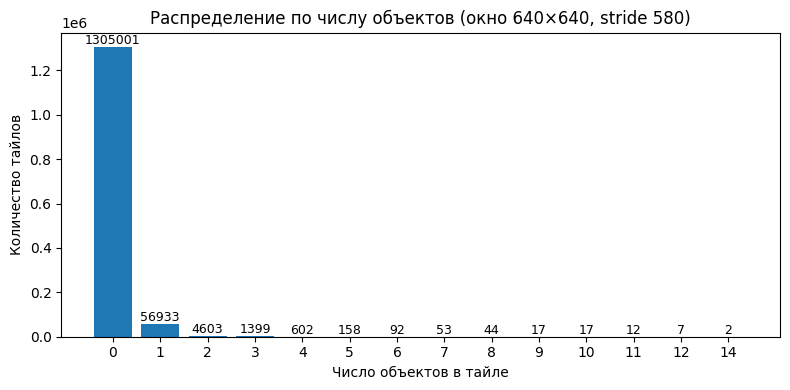

{0: 1305001, 1: 56933, 2: 4603, 3: 1399, 4: 602, 5: 158, 6: 92, 7: 53, 8: 44, 9: 17, 10: 17, 11: 12, 12: 7, 14: 2}


In [13]:
# Пусть у тебя:
# df_images — исходный датафрейм по изображениям (image_path, annotation_path, опц. width/height)
# tiled_df  — результат build_tiled_annotations(...) (только НЕпустые тайлы)

dist = plot_tile_object_distribution(df_images=df, tiled_df=new_df,
                                     window_size=640, stride=580)
print(dist)  # например: {0: 12345, 1: 4567, 2: 890, 3: 42}


In [14]:
def plot_tile_object_distribution_by_cluster(df_images: pd.DataFrame,
                                             tiled_df: pd.DataFrame,
                                             window_size: int = 640,
                                             stride: int = 580):
    """
    Для каждого кластера строит распределение по числу объектов в тайле:
    0 — пустые тайлы, 1, 2, ... — непустые тайлы с соответствующим числом объектов.
    """
    clusters = sorted(df_images['cluster'].unique())
    all_counts = {}

    for cluster_id in clusters:
        # Отбираем изображения и тайлы по этому кластеру
        cluster_images = df_images[df_images['cluster'] == cluster_id]
        cluster_tiles = tiled_df[tiled_df['image_path'].isin(cluster_images['image_path'])]

        # ==== считаем общее число тайлов для каждого изображения ====
        totals = {}
        for _, row in cluster_images.iterrows():
            H, W = _get_image_hw(row)
            xs = _tile_starts(W, window_size, stride)
            ys = _tile_starts(H, window_size, stride)
            totals[row['image_path']] = len(xs) * len(ys)

        # ==== считаем количество объектов в непустых тайлах ====
        per_tile_obj_counts = []
        nonempty_tiles_per_image = {}

        for _, trow in cluster_tiles.iterrows():
            img_path = trow['image_path']
            nobj = _count_lines_in_tile_row(trow)
            if nobj > 0:
                per_tile_obj_counts.append(int(nobj))
                nonempty_tiles_per_image[img_path] = nonempty_tiles_per_image.get(img_path, 0) + 1

        # ==== считаем пустые тайлы ====
        empty_total = 0
        for img_path, total_tiles in totals.items():
            ne = nonempty_tiles_per_image.get(img_path, 0)
            empty_total += max(0, total_tiles - ne)

        # ==== собираем распределение ====
        counts = {0: empty_total}
        if per_tile_obj_counts:
            series = pd.Series(per_tile_obj_counts)
            hist = series.value_counts().sort_index()
            for k, v in hist.items():
                counts[int(k)] = int(v)

        all_counts[cluster_id] = counts

    # ==== визуализация ====
    num_clusters = len(clusters)
    fig, axes = plt.subplots(1, num_clusters, figsize=(4*num_clusters, 4), sharey=True)
    if num_clusters == 1:
        axes = [axes]

    for ax, cluster_id in zip(axes, clusters):
        counts = all_counts[cluster_id]
        keys = sorted(counts.keys())
        values = [counts[k] for k in keys]
        bars = ax.bar([str(k) for k in keys], values)
        ax.set_title(f"Кластер {cluster_id}")
        ax.set_xlabel("Объектов в тайле")
        ax.set_ylabel("Количество тайлов")
        for b in bars:
            h = b.get_height()
            ax.text(b.get_x() + b.get_width()/2, h, str(int(h)), ha='center', va='bottom', fontsize=8)

    plt.suptitle(f"Распределение тайлов по числу объектов (окно {window_size}×{window_size}, stride {stride})")
    plt.tight_layout()
    plt.show()

    return all_counts


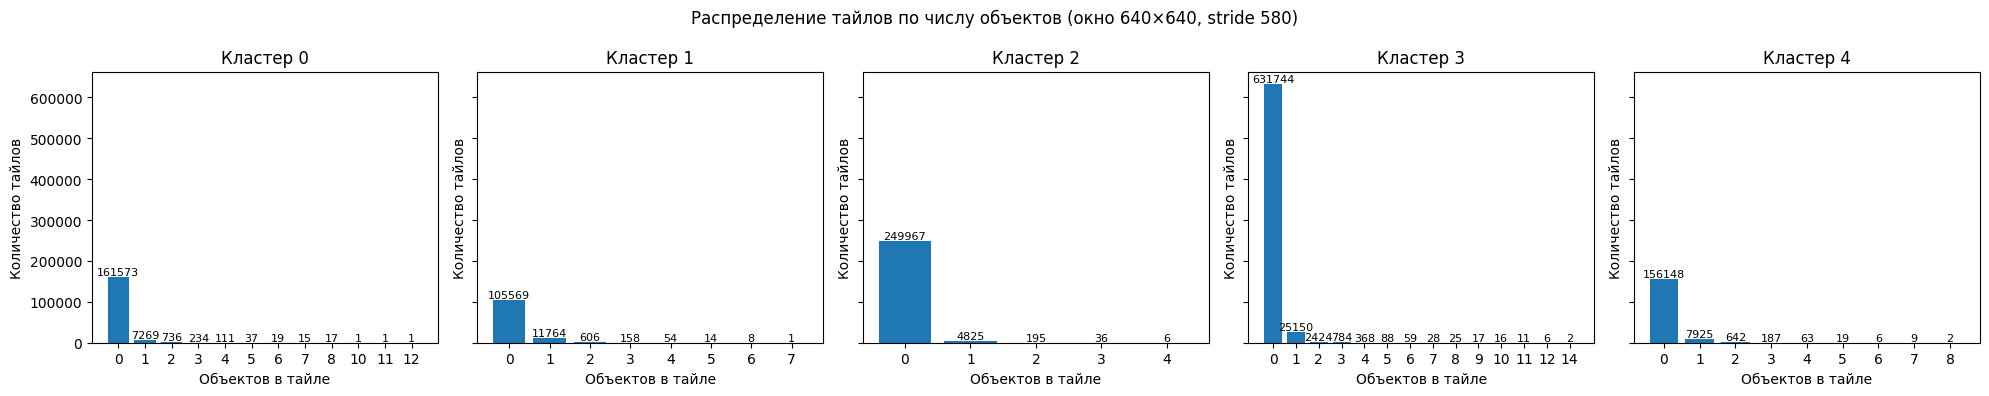

In [15]:
cluster_stats = plot_tile_object_distribution_by_cluster(df_images=df,
                                                         tiled_df=new_df,
                                                         window_size=640,
                                                         stride=580)


In [2]:
import numpy as np, cv2

def gray_world_balance(img):  # сокращённые версии
    img = img.astype(np.float32)
    m = img.mean(axis=(0,1), keepdims=True) + 1e-6
    g = m.mean(axis=-1, keepdims=True)
    img = img * (g / m)
    return np.clip(img, 0, 255).astype(np.uint8)

def soft_denoise(img, strength=0.8):
    if strength <= 0: return img
    return cv2.bilateralFilter(img, 7, int(25*strength), int(25*strength))

def clahe_L(img, clip=2.5, tiles=(8,8)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    l = cv2.createCLAHE(clipLimit=float(clip), tileGridSize=tiles).apply(l)
    return cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2BGR)

def adaptive_gamma(img, target_mean=0.5, clip_gamma=(0.7,1.3)):
    Y = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[...,0].astype(np.float32)/255.0
    gamma = float(np.clip(np.log(max(target_mean,1e-6))/np.log(Y.mean()+1e-6), *clip_gamma))
    x = np.clip(img.astype(np.float32)/255.0, 0, 1)
    return np.clip(np.power(x, gamma)*255, 0, 255).astype(np.uint8)

def unsharp_mask(img, sigma=1.2, amount=0.6):
    blur = cv2.GaussianBlur(img, (0,0), sigma)
    return cv2.addWeighted(img, 1+amount, blur, -amount, 0)

def _params_from_stats_like(mv, ent, ms):
    p = dict(gray_world=True, denoise_strength=0.8, clahe_clip=2.5, clahe_tiles=(8,8),
             gamma_target_mean=0.5, gamma_clip=(0.7,1.3), unsharp_sigma=1.2, unsharp_amount=0.6)
    if mv < 0.42: p['gamma_target_mean']=0.58; p['clahe_clip']=max(p['clahe_clip'],3.0)
    elif mv > 0.65: p['gamma_target_mean']=0.47
    if ent > 0.65: p['denoise_strength']=1.0
    elif ent < 0.35: p['denoise_strength']=0.5; p['unsharp_amount']=0.7
    if ms < 0.3: p['clahe_clip']=max(p['clahe_clip'],3.0)
    return p

def preprocess_pipeline_cluster(img_bgr, mv, ent, ms):
    p = _params_from_stats_like(mv, ent, ms)
    out = img_bgr
    if p['gray_world']: out = gray_world_balance(out)
    if p['denoise_strength']>0 and ent>0.55: out = soft_denoise(out, p['denoise_strength'])
    if p['clahe_clip']>0 and (mv<0.45 or mv>0.65 or ms<0.3): out = clahe_L(out, p['clahe_clip'], p['clahe_tiles'])
    if abs(mv - p['gamma_target_mean'])>0.05: out = adaptive_gamma(out, p['gamma_target_mean'], p['gamma_clip'])
    if p['unsharp_amount']>0 and ent<0.7: out = unsharp_mask(out, p['unsharp_sigma'], p['unsharp_amount'])
    return out

In [3]:
import os
import math
import shutil
import random
from pathlib import Path
from typing import Optional, Sequence, Tuple, Dict, List
import torch
import gc
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
import os, math, gc, cv2, numpy as np, torch, kornia as K
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


df=pd.read_pickle(r"E:\DroneFootageDataset\image_df.pkl")
new_df=pd.read_pickle(r"E:\DroneFootageDataset\tiled_df.pkl")
# ==== вспомогалки из предыдущих блоков ====

def _tile_starts(L, size, stride):
    if L <= size:
        return [0]
    starts = list(range(0, max(L - size, 0) + 1, stride))
    last = L - size
    if starts[-1] != last:
        starts.append(last)
    return starts

def _get_image_hw(row):
    if ('width' in row and 'height' in row
        and pd.notna(row['width']) and pd.notna(row['height'])):
        return int(row['height']), int(row['width'])
    img = cv2.imread(row['image_path'])
    if img is None:
        raise FileNotFoundError(row['image_path'])
    H, W = img.shape[:2]
    return H, W

def _count_lines_in_tile_row(tile_row):
    if 'lines' in tile_row and isinstance(tile_row['lines'], (list, tuple)):
        return len(tile_row['lines'])
    p = tile_row.get('tile_annotation_path', None)
    if p and isinstance(p, str) and os.path.exists(p):
        with open(p, 'r', encoding='utf-8') as f:
            return sum(1 for _ in f if _.strip())
    return 0

# ==== экспорт датасета под YOLO для ОДНОГО кластера ====

def export_cluster_dataset(
    df_images: pd.DataFrame,
    tiled_df: pd.DataFrame,
    cluster_id: int,
    out_dir: str,
    window_size: int = 640,
    stride: int = 580,
    val_split: float = 0.10,
    rng_seed: int = 42,
    jpeg_quality: int = 90,
    apply_cluster_preprocess: bool = True,   # <-- включён по умолчанию
):
    """
    Собирает датасет для выбранного кластера:
      out_dir/
        images/{train,val}/*.jpg
        labels/{train,val}/*.txt
        data.yaml
    Возвращает путь к data.yaml.
    """
    import random, shutil
    from pathlib import Path
    import numpy as np, cv2

    # --- helpers (минимальные, как раньше) ---
    def gray_world_balance(img):
        img = img.astype(np.float32)
        m = img.mean(axis=(0,1), keepdims=True) + 1e-6
        g = m.mean(axis=-1, keepdims=True)
        img = img * (g / m)
        return np.clip(img, 0, 255).astype(np.uint8)

    def soft_denoise(img, strength=0.8):
        if strength <= 0: return img
        return cv2.bilateralFilter(img, 7, int(25*strength), int(25*strength))

    def clahe_L(img, clip=2.5, tiles=(8,8)):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(lab)
        l2 = cv2.createCLAHE(clipLimit=float(clip), tileGridSize=tiles).apply(l)
        return cv2.cvtColor(cv2.merge([l2,a,b]), cv2.COLOR_LAB2BGR)

    def adaptive_gamma(img, target_mean=0.5, clip_gamma=(0.7,1.3)):
        Y = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[...,0].astype(np.float32)/255.0
        mean_y = float(Y.mean()+1e-6)
        import math
        gamma = float(np.clip(np.log(max(target_mean,1e-6))/np.log(mean_y), clip_gamma[0], clip_gamma[1]))
        x = np.clip(img.astype(np.float32)/255.0, 0, 1)
        return np.clip(np.power(x, gamma)*255, 0, 255).astype(np.uint8)

    def unsharp_mask(img, sigma=1.2, amount=0.6):
        blur = cv2.GaussianBlur(img, (0,0), sigma)
        return cv2.addWeighted(img, 1+amount, blur, -amount, 0)

    def _params_from_stats_like(mv, ent, ms):
        p = dict(gray_world=True, denoise_strength=0.8, clahe_clip=2.5, clahe_tiles=(8,8),
                 gamma_target_mean=0.5, gamma_clip=(0.7,1.3),
                 unsharp_sigma=1.2, unsharp_amount=0.6)
        if mv < 0.42:
            p['gamma_target_mean'] = 0.58
            p['clahe_clip'] = max(p['clahe_clip'], 3.0)
        elif mv > 0.65:
            p['gamma_target_mean'] = 0.47
        if ent > 0.65:
            p['denoise_strength'] = 1.0
        elif ent < 0.35:
            p['denoise_strength'] = 0.5
            p['unsharp_amount'] = 0.7
        if ms < 0.3:
            p['clahe_clip'] = max(p['clahe_clip'], 3.0)
        return p

    def preprocess_pipeline_cluster(img_bgr, mv, ent, ms):
        p = _params_from_stats_like(mv, ent, ms)
        out = img_bgr
        if p['gray_world']:
            out = gray_world_balance(out)
        if p['denoise_strength'] > 0 and ent > 0.55:
            out = soft_denoise(out, p['denoise_strength'])
        if p['clahe_clip'] > 0 and (mv < 0.45 or mv > 0.65 or ms < 0.3):
            out = clahe_L(out, p['clahe_clip'], p['clahe_tiles'])
        if abs(mv - p['gamma_target_mean']) > 0.05:
            out = adaptive_gamma(out, p['gamma_target_mean'], p['gamma_clip'])
        if p['unsharp_amount'] > 0 and ent < 0.7:
            out = unsharp_mask(out, p['unsharp_sigma'], p['unsharp_amount'])
        return out

    def _count_lines_in_tile_row(tile_row):
        if 'lines' in tile_row and isinstance(tile_row['lines'], (list, tuple)):
            return len(tile_row['lines'])
        p = tile_row.get('tile_annotation_path', None)
        if p and isinstance(p, str) and os.path.exists(p):
            with open(p, 'r', encoding='utf-8') as f:
                return sum(1 for _ in f if _.strip())
        return 0

    # --- rng ---
    random.seed(rng_seed)
    np.random.seed(rng_seed)

    # --- dirs ---
    out_dir = Path(out_dir)
    if out_dir.exists():
        shutil.rmtree(out_dir)
    (out_dir / "images" / "train").mkdir(parents=True, exist_ok=True)
    (out_dir / "images" / "val").mkdir(parents=True, exist_ok=True)
    (out_dir / "labels" / "train").mkdir(parents=True, exist_ok=True)
    (out_dir / "labels" / "val").mkdir(parents=True, exist_ok=True)

    # --- изображения и тайлы этого кластера ---
    cluster_imgs = df_images[df_images["cluster"] == cluster_id]["image_path"].unique().tolist()
    cluster_tiles = tiled_df[tiled_df["image_path"].isin(cluster_imgs)].copy()

    # — только непустые тайлы —
    cluster_tiles["nobj"] = cluster_tiles.apply(_count_lines_in_tile_row, axis=1)
    cluster_tiles = cluster_tiles[cluster_tiles["nobj"] > 0]
    if len(cluster_tiles) == 0:
        raise RuntimeError(f"В кластере {cluster_id} нет непустых тайлов.")

    # --- СРЕДНИЕ ПО КЛАСТЕРУ ИЗ df_images ---
    if apply_cluster_preprocess:
        # требуются колонки: mean_value, entropy, mean_saturation
        needed = {"mean_value", "entropy", "mean_saturation"}
        if not needed.issubset(set(df_images.columns)):
            raise ValueError("Для кластерного препроцессинга нужны колонки mean_value, entropy, mean_saturation в df_images.")
        sub = df_images[df_images["cluster"] == cluster_id][["mean_value","entropy","mean_saturation"]]
        mv = float(sub["mean_value"].mean())
        ent = float(sub["entropy"].mean())
        ms = float(sub["mean_saturation"].mean())

    # --- split по ИЗОБРАЖЕНИЯМ (не размешиваем тайлы одного изображения меж train/val) ---
    imgs = list(sorted(set(cluster_tiles["image_path"].tolist())))
    random.shuffle(imgs)
    n_val = max(1, int(round(len(imgs) * val_split)))
    val_set = set(imgs[:n_val])
    train_set = set(imgs[n_val:])

    # --- экспорт ---
    counter = 0
    for _, trow in cluster_tiles.iterrows():
        img_path = trow["image_path"]
        subset = "val" if img_path in val_set else "train"

        bgr = cv2.imread(img_path)
        if bgr is None:
            continue
        H, W = bgr.shape[:2]

        x0, y0 = int(trow["tile_x0"]), int(trow["tile_y0"])
        w_tile = int(trow.get("tile_w", window_size))
        h_tile = int(trow.get("tile_h", window_size))

        tile = bgr[y0:y0+h_tile, x0:x0+w_tile]
        if tile.shape[0] != window_size or tile.shape[1] != window_size:
            tile = cv2.copyMakeBorder(
                tile,
                0, window_size - tile.shape[0],
                0, window_size - tile.shape[1],
                cv2.BORDER_CONSTANT, value=(114,114,114)
            )

        # === кластерный препроцессинг (по средним кластера из df_images) ===
        if apply_cluster_preprocess:
            tile = preprocess_pipeline_cluster(tile, mv, ent, ms)

        stem = f"c{cluster_id}_{counter:09d}"
        img_out = out_dir / "images" / subset / f"{stem}.jpg"
        lbl_out = out_dir / "labels" / subset / f"{stem}.txt"

        cv2.imwrite(str(img_out), tile, [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)])

        lines = trow["lines"] if isinstance(trow["lines"], list) else []
        if len(lines) == 0:
            continue
        with open(lbl_out, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))

        counter += 1

    # --- data.yaml ---
    data_yaml = out_dir / "data.yaml"
    data_yaml.write_text(
        f"""# auto-generated
path: {out_dir.as_posix()}
train: images/train
val: images/val
names:
  0: person
""",
        encoding="utf-8"
    )
    return str(data_yaml)


# ==== обучение YOLO11L для одного кластера ====

def finetune_yolo11l_for_cluster(
    data_yaml_path: str,
    weights: str = "yolo11l.pt",
    epochs: int = 20,
    imgsz: int = 640,
    batch: int = 16,
    lr0: float = 0.003,
    device: str = "cuda:0",
    project: str = "runs/cluster_ft",
    name: Optional[str] = None,
    freeze_backbone: bool = True,
    close_mosaic_last_n: int = 10,
):
    """
    Запускает fine-tuning YOLO11-L на сгенерированном датасете.
    """
    model = YOLO(weights)

    # Параметры тренировки. Замораживаем backbone на первых эпохах — полезно при небольших кластерах.
    # В YOLOv8/11 параметр 'freeze' принимает список индексов или число уровней.
    # Надёжный вариант — сначала «легкий» прогрев головы, затем разморозка:
    if freeze_backbone:
        # «двухфазка»: 3 эпохи с freeze, затем оставшиеся с разморозкой
        warmup_epochs = min(3, epochs//4 if epochs >= 8 else 2)
        model.train(
            data=data_yaml_path,
            epochs=warmup_epochs,
            imgsz=imgsz,
            batch=batch,
            lr0=lr0,
            device=device,
            project=project,
            name=(name + "_warm") if name else "warm",
            freeze=10,                  # заморозить первые слои (эвристика)
            close_mosaic=close_mosaic_last_n
        )
        gc.collect()
        try: 
            torch.cuda.empty_cache()
        except: 
            pass
        # дообучаем без freeze
        model.train(
            data=data_yaml_path,
            epochs=epochs - warmup_epochs,
            imgsz=imgsz,
            batch=batch,
            lr0=lr0,
            device=device,
            project=project,
            name=name,
            freeze=0,
            close_mosaic=close_mosaic_last_n
        )
    else:
        model.train(
            data=data_yaml_path,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            lr0=lr0,
            device=device,
            project=project,
            name=name,
            freeze=0,
            close_mosaic=close_mosaic_last_n
        )

# ==== удобная обёртка: экспорт и обучение по ВСЕМ кластерам ====

def finetune_per_cluster(
    df_images: pd.DataFrame,
    tiled_df: pd.DataFrame,
    cluster_ids: Optional[Sequence[int]] = None,
    out_root: str = "./yolo_cluster_datasets",
    window_size: int = 640,
    stride: int = 580,
    epochs: int = 20,
    batch: int = 16,
    device: str = "cuda:0",
    weights: str = "yolo11l.pt",
    project: str = "runs/cluster_ft",
    val_split: float = 0.10,
    rng_seed: int = 42,
):
    """
    По умолчанию проходит по всем кластерам из df_images['cluster'].
    Для каждого:
      1) экспортирует тайловый датасет на диск,
      2) запускает fine-tuning YOLO11L.
    """
    clusters = sorted(df_images["cluster"].unique().tolist()) if cluster_ids is None else list(cluster_ids)

    for cid in clusters:
        ds_dir = Path(out_root) / f"cluster_{cid}"
        yaml_path = export_cluster_dataset(
            df_images=df_images,
            tiled_df=tiled_df,
            cluster_id=cid,
            out_dir=str(ds_dir),
            window_size=window_size,
            stride=stride,
            val_split=val_split,
            rng_seed=rng_seed
        )
        gc.collect()
        try: 
            torch.cuda.empty_cache()
        except: 
            pass

        finetune_yolo11l_for_cluster(
            data_yaml_path=yaml_path,
            weights=weights,
            epochs=epochs,
            imgsz=window_size,   # 640
            batch=batch,
            device=device,
            project=project,
            name=f"c{cid}"
        )
        gc.collect()
        try: 
            torch.cuda.empty_cache()
        except: 
            pass


cuda


In [ ]:
if __name__ == "__main__":
    finetune_per_cluster(df_images=df,tiled_df=new_df)

In [7]:
from pathlib import Path
import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

FEATURES = ["entropy", "mean_hue", "mean_saturation", "mean_value"]
TARGET_COL = "cluster"

def predict_and_compare(kmeans_path, df_path, n=100, seed=42, random=True):
    # load
    kmeans = joblib.load(kmeans_path)
    df = pd.read_pickle(df_path) 

    # check
    missing = [c for c in FEATURES if c not in df.columns]
    if missing:
        raise KeyError(f"В df отсутствуют признаки: {missing}")
    if TARGET_COL not in df.columns:
        raise KeyError(f"В df нет колонки '{TARGET_COL}'")

    # sample
    if n > 0 and n < len(df):
        df = df.sample(n=n, random_state=seed) if random else df.head(n)
    df = df.reset_index(drop=True)

    # predict
    X = df[FEATURES].astype(np.float32).values
    y_true = df[TARGET_COL].astype(int).values
    y_pred = kmeans.predict(X)

    # metrics
    print(f"Accuracy: {(y_pred == y_true).mean():.4f}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, zero_division=0))

    return df.assign(pred_cluster=y_pred)

# ==== Пример вызова в ноутбуке ====
df_with_pred = predict_and_compare(
    kmeans_path="kmeans_model.pkl",
    df_path=r"E:\DroneFootageDataset\image_df.pkl",
    n=50000,            # сколько проверять
    seed=42,
    random=True       # True — случайно, False — первые n
)


Accuracy: 1.0000
[[ 4644     0     0     0     0]
 [    0  6312     0     0     0]
 [    0     0  3140     0     0]
 [    0     0     0 16099     0]
 [    0     0     0     0  4533]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4644
           1       1.00      1.00      1.00      6312
           2       1.00      1.00      1.00      3140
           3       1.00      1.00      1.00     16099
           4       1.00      1.00      1.00      4533

    accuracy                           1.00     34728
   macro avg       1.00      1.00      1.00     34728
weighted avg       1.00      1.00      1.00     34728

